# Bayes (Part II)

In [28]:
import numpy as np
import matplotlib.pyplot as plt

## The Metropolis-Hastings algorithm

In the lecture this week, we have seen the _Metropolis-Hastings_ algorithm, which allows us to get samples from an _unnormalized_ distribution function, i.e., a function that returns a probability multiplied by some constant factor. Note that this can be any distribution (although in practice we will need it to get samples from an unnormalized posterior).

First of all, have a look at the description of the algorithm and try to implement it as described here.
> __**NOTE**__ You can find the implemented algo at the bottom of this notebook, but please try by yourself before looking at it!

In [ ]:
def mcmc(nsamples, unnorm_prob_f, proposalf, burnin=100, initial=0.):
    """
    Parameters
    ----------
    nsamples: int
        Number of samples to draw (includes burnin)
    unnorm_prob_f: func
        Function taking a point in the support and
        returning its unnormalized probability
    proposalf: func
        Function that takes current position
        and returns a proposal for where to move next
    burnin: int
        Number of initial samples to exclude
    initial: float or func
        If float, starts from that point.
        If func, starts from the output of initial()
    Returns
    -------
    list
        A list of samples
    """
    
    # set initial point in variable 'current' and 
    # calculate current probability ('curr_prob')
    # ADD CODE HERE
    
    # we put the samples in list 'states'
    states = []
    for i in range(nsamples):
        
        # append current position to states
        # ADD CODE HERE
        
        # proposes a new point
        # ADD CODE HERE
        
        # calculate unnormalized probability 
        # at proposed point
        # ADD CODE HERE
        
        # calculates probability of acceptance 
        # in variable 'acceptance'
        # ADD CODE HERE
        
        if np.random.random_sample() < acceptance:
            # if acceptance is higher than random btw 0 and 1,
            # accept move, else stay where you are (i.e. do nothing)
            # ADD CODE HERE
    
    # return list of samples
    return states[burnin:]

This algorithm has a lot of pros:
- Suprisingly simple to implement
- If we get enough samples it is guaranteed to converge to the true posterior!
- Works for both continuous and discrete parameter spaces
But it also has some cons:
- Can be very slow to converge
- Does not work well with highly dimensional spaces
- There is no way to tell if it converged to the true posterior

In general, we should get as many samples as possible and run multiple chains with different initial points, to see if they converged to the same distribution.

## Getting samples from an unnormalized normal distribution

The simplest application is to get samples from a distribution that we can calculate exactly, and see if the algorithm converges to it. Let's take the standard normal distribution, which has density function:

$$
\varphi (z)= \frac {1}{\sqrt {2\pi }} e^{-{\frac {z^{2}}{2}}}
$$

let's write a function to calculate this probability density:

In [34]:
def normal(x,mu=0,sigma=1):
    """
    Probability density of normal distribution at x
    """
    numerator = np.exp((-(x-mu)**2)/(2*sigma**2))
    denominator = sigma * np.sqrt(2*np.pi)
    return numerator/denominator

And let's test this function to make sure it does what we expect:

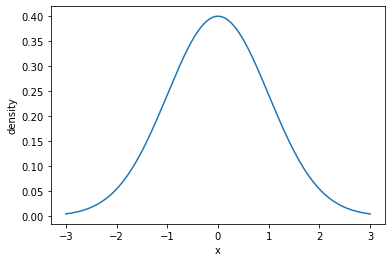

In [37]:
xs = np.linspace(-3,3,1000)
plt.plot(xs, normal(xs))
plt.xlabel('x')
plt.ylabel('density')
plt.show()

Now suppose that we didn't have the explicit formula for the distribution, but rather some black-box function where $\varphi$ is multiplied by an unknown constant $K$:

$$
\varphi' (z)= K \frac {1}{\sqrt {2\pi }} e^{-{\frac {z^{2}}{2}}}
$$

> __**NOTE**__: If $K$ is equal to the normalization constant $\sqrt {2\pi }$, $\varphi' (z)$ becomes just $e^{-{\frac {z^{2}}{2}}}$. This is essentially the trick we will use to sample from the posterior, where we don't have the posterior as such, but we can calculate the posterior multiplied by $P(D)$.

Now we can use our mcmc function above to take samples from the distribution:

In [39]:
samples = mcmc(
    # Number of samples
    100000,
    # Unnormalized density function
    lambda x: np.exp(-x**2 / 2),
    # Proposal function from point x
    lambda x: np.random.normal(loc=x, scale=0.1),
)

We can plot a histogram of the samples and compare it to the true distribution, and if you wrote the MCMC function correctly, they should look very close:

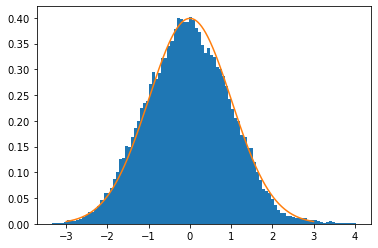

In [33]:
# plot a histogram of the samples
plt.hist(samples, bins=100, density=True)
# also plot the true distribution, just to be sure!
xs = np.linspace(-3,3,1000)
plt.plot(xs, normal(xs))
plt.show()

## Using MHMC for Bayesian inference: categorization in continuous space

Now recall the categorization case that we saw in class: we observe some samples from an unknown category, and we have to form a posterior over the position of the unseen category's boundaries. The case we have seen in class has discrete boundaries, and therefore we could in theory calculate the posterior directly: consider all the possible hypotheses (categories) $H$, calculate $P(H) P(D \mid H)$, and sum it all to find $P(D)$.

However, now imagine the case where we have a _continuous_ space, and so infinitely many categories. The probability density of sampling a certain observation from a category is still 0 if the observation lies outside the category and $1/|H|$ otherwise, but now the category $H$ can have a float size (e.g., category [-1, 0.5] has size 1.5). Now it becomes difficult to calculate the $P(D)$, because we can't easily integrate over all categories!

However, if we define some prior over hypotheses (i.e. the categories), we can still easily calculate the numerator of the posterior, namely $P(H) P(D \mid H)$, for specific categories. A simple prior can be defined as follows:

$$
p(H) = \phi(x=l_H, \mu=0, \sigma=10) \; \phi(x=u_H, \mu=0, \sigma=10)
$$

where $\phi$ is the probability density function of a normal distribution, $l_H$ is the lower bound, and $u_H$ is the upper bound. 

In [81]:
def prior_f(boundaries):
    lb, ub = boundaries
    return normal(lb, sigma=10) * normal(ub, sigma=10)

Likelihood can be defined as discussed above:

$$
p(D \mid H) = \prod_{d \in D} \left( |H|^{-1} \text{ if } d \in H \text{ else } 0 \right)
$$

where $D$ is a set of observations (points from the unobserved category).

In [80]:
def likelihood_f(data, boundaries):
    lb, ub = boundaries
    compatible = all([lb < i < ub for i in data])
    if compatible:
        return 1/(ub-lb)
    else:
        return 0

With the prior and the likelihood as defined above, we can write a function that given some data returns the unnormalized posterior function (i.e. a function form a category to the unnormalized posterior probability of the category given the data):

In [80]:
def define_unnorm_posterior(data):
    def unnorm_posterior(boundaries):
        return (
            likelihood_f(data, boundaries) * 
            prior_f(boundaries)
        )
    return unnorm_posterior

Finally, we just need a proposal function that takes a current category and proposes a new one. The proposal function here does this by moving the category up or down and stretching it by some amount:

In [105]:
def proposal_f(current_boundaries):
    # transform boundaries linearly
    # (i.e., move up and down and stretch)
    shift = np.random.normal()
    # we want the stretch to be always positive
    # to preserve order of upper and lower bound
    # (otherwise all samples with wrong order would
    # have prob 0 in the likelihood function)
    # Moreover, a stretching by some value x
    # should be as likely as a contraction by x
    # To preserve symmetry!
    stretch = np.exp(np.random.normal())
    return shift + stretch*current_boundaries

Let's check the distribution of the upper and lower bounds of the proposals starting from category [-1,1]:

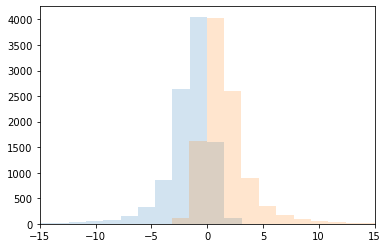

In [106]:
proposed = [proposal_f(np.array([-1,1])) for _ in range(10000)]
lbs, ubs = np.array(proposed).T
plt.hist(lbs, bins=100, alpha=0.2)
plt.hist(ubs, bins=100, alpha=0.2)
plt.xlim(-15, 15)
plt.show()

Now we are ready to run approximate Bayesian inference on some data! Let's define some data first:

In [71]:
observations = [0.1, 2., 1.1]

Take samples from the posterior distribution:

In [83]:
samples = mcmc(
    # Number of samples
    500000,
    # Unnormalized density function
    define_unnorm_posterior(observations),
    # Proposal function from point x
    proposal_f,
    initial=np.array([-0.5, 0.5])
)

/tmp/ipykernel_2721/2883728898.py:42: RuntimeWarning: invalid value encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)
/tmp/ipykernel_2721/2883728898.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance = min(move_prob/curr_prob,1)


Let's plot the posterior distributions of upper and lower bound:

In [85]:
lbs, ubs = np.array(samples).T

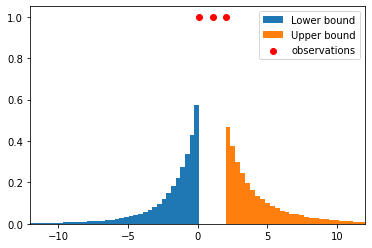

In [86]:
plt.hist(lbs, bins=100, density=True, label='Lower bound')
plt.hist(ubs, bins=100, density=True, label='Upper bound')
plt.xlim(-12, 12)
plt.scatter(
    observations, 
    [1.]*len(observations),
    color='red',
    label='observations'
)
plt.legend()
plt.show()

> __QUESTION__ What happens if we add more observations? Do you see the size effect in continuous space?

> __EXERCISE__ (if there is time left at the end) Write a version of this inference model for 2-d space, where categories are squares and observations are points in 2d space.

## Using MHMC in discrete spaces

We can use Metropolis-Hastings for discrete hypotheses spaces too! The basic idea is the same: we move around the space of hypotheses, calculating the unnormalized posterior for each point, and accepting new moves according to the rule described in the algo. The only complication is that we can't use the normal distribution centered at the current position as a proposal distribution, but we must come up with something different. 

As an example which will be useful in the future, consider the space of sentences generated by a PCFG as the space of hypotheses. For instance, the following PCFG:

$$
S \rightarrow a | b | Sa | Sb
$$

with uniform substitution probabilities (each $1/3$). The space of hypotheses then would be: 'a', 'b', 'aa', 'ab', 'ba', 'bb', and so on. 

In [132]:
def complete(incomplete_sentence):
    result = incomplete_sentence
    options = ['a', 'b', 'Sa', 'Sb']
    while 'S' in result:
        result = np.random.choice(options) + result[1:]
    return result

In [155]:
# test function
complete('Saa')

'aaa'

The probability of a specific sentence of length $n$ then is $4^{-n}$ (can you see why?). Let's verify by sampling a bunch of sentences and finding the proportion of times we sample each one:

In [175]:
n = 10000
samples = [complete('S') for _ in range(n)]
sentences, counts = np.unique(samples, return_counts=True)
argsort = np.argsort(counts)[::-1]
sentences = sentences[argsort]
counts = counts[argsort] / n

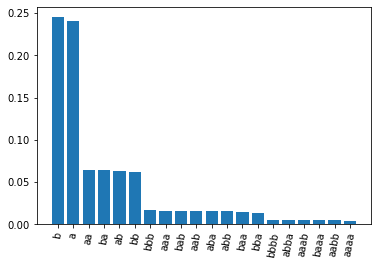

In [178]:
plt.bar(x=sentences[:20], height=counts[:20])
plt.xticks(rotation=80)
plt.show()

Based on this, it is easy to calculate the probability of each sentence:

In [109]:
def prior_f(sentence):
    return 4**(-len(sentence))

In [112]:
# example of prior calculation
prior_f('a')

0.25

We want to learn the sentence that produces some data. If we can see the sentence directly, this is easy: just look at the sentence and we're done. However, suppose that we can't see the sentence directly, but we see a 'noisy' version of it, where possibly some characters have been added at the end, where:
- nothing is added with probability 1/3.
- 'a' and 'b' are added with probability 1/3 each.

We can calculate the resulting observation probability:

In [128]:
def likelihood_f(observations, sentence):
    likelihood = 1
    for observation in observations:
        # Calculates probability of observation given true sentence
        if observation == sentence:
            likelihood *= 1/3
        elif observation.startswith(sentence):
            likelihood *= 1/3**(len(observation)-len(sentence))
        else:
            return 0
    return likelihood

In [130]:
# test the function
print(likelihood_f(['abaa', 'abaaa', 'aba'], 'ab'))
print(likelihood_f(['abaa', 'abaaa', 'abab'], 'ab'))
print(likelihood_f(['abaa', 'abaaa', 'abab'], 'abb'))

0.001371742112482853
0.00045724737082761767
0


Like in the example above, we can now calculate the unnormalized posterior:

In [194]:
def define_unnorm_posterior(data):
    def unnorm_posterior(sentence):
        return (
            likelihood_f(data, sentence) * 
            prior_f(sentence)
        )
    return unnorm_posterior

Finally, we need a proposal distribution, which brings us from a current sentence to a possible next step. For MHMC to work as written above, it has to be the case that the probability of going from $x$ to $x'$ is the same as the probability of going from $x'$ to $x$. If this is not the case, we need to multiply the value of `acceptance` in `mcmc` by $\frac{P(x' \rightarrow x) }{ P(x \rightarrow x')}$ to balance things out.

In practice, we will use the _subtree-regeneration_ transition distribution proposed at p.153 in Goodman, Noah D., Joshua B. Tenenbaum, Jacob Feldman, and Thomas L. Griffiths. “A Rational Analysis of Rule-Based Concept Learning.” Cognitive Science 32, no. 1 (2008): 108–54. https://doi.org/10.1080/03640210701802071. It works as follows, starting from current sentence $x$:
- Sample a node $n$ at random from the parse tree of $x$
- Remove everything below $n$ and replace $n$ with appropriate non-terminal, generating a tree $y$ containing non-terminals.
- Complete $y$ with the PCFG, obtaining new sentence $x'$.
- The acceptance probability from `mcmc` then gets additionally multiplied by:

\begin{align}
\frac{p(x' \rightarrow x)}{p(x \rightarrow x')} 
&= 
\frac{ P(\text{sampling node $n$ from $x'$}) }{ P(\text{sampling node $n$ from $x'$}) } 
\frac{ P(x \mid \text{PCFG}) }{ P(x' \mid \text{PCFG}) } \\
&= \frac{|x'|^{-1}}{|x|^{-1}} \frac{4^{-|x|}}{4^{-|x'|}} \\
&= \frac{|x|}{|x'|} \frac{4^{-|x|}}{4^{-|x'|}}
\end{align}


In [181]:
def transition_f(current):
    n = np.random.randint(len(current))
    truncated = 'S' + current[:n]
    return complete(truncated)

In [188]:
# test the function
transition_f('aba')

'bbb'

In [192]:
def acceptance_f(current, proposed, unnorm_prob_f):
    move_when_lower = (
        (unnorm_prob_f(proposed) * len(current) * 0.25**len(current))
        /
        (unnorm_prob_f(current) * len(proposed) * 0.25**len(proposed))
    )
    return min(
        move_when_lower,
        1
    )

In [193]:
def mcmc(nsamples, unnorm_prob_f, proposalf, burnin=100, initial=0.):
    """
    Same as mcmc above but with different acceptance_f
    """
    
    current = initial() if callable(initial) else initial
    curr_prob = unnorm_prob_f(current)
    states = []
    for i in range(nsamples):
        states.append(current)
        movement = proposalf(current)
        move_prob = unnorm_prob_f(movement)
        acceptance = acceptance_f(
            current, 
            movement,
            unnorm_prob_f
        )
        if np.random.random_sample() < acceptance:
            current = movement
            curr_prob = move_prob
    return states[burnin:]

Define some observations:

In [196]:
observations = ['aabaab', 'aaba', 'aabaaaa']

Take samples with our algorithm:

In [198]:
samples = mcmc(
    100000,
    define_unnorm_posterior(observations),
    transition_f,
    initial='a'
)

Plot the posterior distribution:

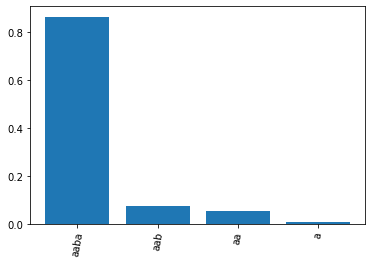

In [204]:
sentences, counts = np.unique(samples, return_counts=True)
argsort = np.argsort(counts)[::-1]
sentences = sentences[argsort]
counts = counts[argsort] / len(samples)

plt.bar(x=sentences, height=counts)
plt.xticks(rotation=80)
plt.show()

Various things to be noticed:
- The most likely sentence is the longest sentence that all the observations share, namely 'aaba'
- The second most likely is 'aab', because it would be a 'suspicious' coincidence if all observations independently produced an 'a' right after 'aab', if the true sentence is indeed 'aab'.
- Same, but even more so, applies to 'aa' and 'a'.
- So even though 'aaba' is a priori less likely than 'a', it get a higher posterior probability because of the likelihood!

## Homework

Third (and last) homeworks set! Consider the following CFG (interpret it as a PCFG with uniform probabilities), where each sentence from this grammar is an integer:
$$
S \rightarrow 1 | S+1 | S-1
$$
Note that there are multiple way to arrive at the same integer. E.g. $I(1+1-1)=I(1)$.

1. Write a function `prior_f` that takes a sentence produced by the PCFG and returns its probability in the PCFG.

Assume that there is a true (unknown) sentence $H$ that we are trying to infer based on some observations ${o_1, \dots, o_n}$. The observations aren't just the integer defined by the sentence, but rather each observation is equal to the integer defined by the sentence plus some normally distributed noise. The likelihood function therefore is as follows:
$$
p(o \mid H) = P(H \mid \text{PCFG}) \; \phi(x= o-I(H), \mu=0, \sigma=2.)
$$
as usual, $I$ is the interpretation function, $\phi$ is the density function of the normal distribution. For instance if the true sentence was `1+1`, we might observe 1.94.

2. Write a function `likelihood_f` that calculates the probability of a list of observations given a sentence.
> __HINT__ First find the integer $i$ defined by the sentence, then for each observation find the difference between $i$ and the observation, then find the probability of those differences (given that they are samples from a normal with $\mu=0$ and $\sigma=2$), and multiply those probabilities together.
3. Write a function to calculate the unnormalized posterior. This is essentially what the `define_unnorm_posterior` function above does.

4. Write a transition function: a function that takes a current sentence $x$ and returns a randomly generated proposal $x'$. You can modify the subtree-regeneration above to adapt it to this case.
5. Using mcmc, draw 100000 samples from $P(H \mid D)$.

## Implemented MHMC

In [35]:
def mcmc(nsamples, unnorm_prob_f, proposalf, burnin=100, initial=0.):
    """
    Parameters
    ----------
    nsamples: int
        Number of samples to draw (includes burnin)
    unnorm_prob_f: func
        Function taking a point in the support and
        returning its unnormalized probability
    proposalf: func
        Function that takes current position
        and returns a proposal for where to move next
    burnin: int
        Number of initial samples to exclude
    initial: float or func
        If float, starts from that point.
        If func, starts from the output of initial()
    Returns
    -------
    list
        A list of samples
    """
    
    current = initial() if callable(initial) else initial
    curr_prob = unnorm_prob_f(current)
    
    # we put the samples in list 'states'
    states = []
    for i in range(nsamples):
        
        # append current position to states
        states.append(current)
        
        # proposes a new point
        movement = proposalf(current)
        
        # calculate unnormalized probability 
        # at proposed point
        move_prob = unnorm_prob_f(movement)
        
        # calculates probability of acceptance
        acceptance = min(move_prob/curr_prob,1)
        
        # if acceptance is higher than random btw 0 and 1,
        # accept move, else stay where you are (i.e. do nothing)
        if np.random.random_sample() < acceptance:
            current = movement
            curr_prob = move_prob
    
    # return list of samples
    return states[burnin:]